In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from lesson_functions import *

In [2]:
import os
import glob

basedir = 'vehicles/'
image_types = os.listdir(basedir)

cars = []
for imtype in image_types:
        cars.extend(glob.glob(basedir+imtype+'/*'))

print ('Number of Vehicle Images found:', len(cars))
with open ("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)

notcars = []
for imtype in image_types:
        notcars.extend(glob.glob(basedir+imtype+'/*'))

print ('Number of Non-Vehicle Images found:', len(notcars))
with open ("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


C:\Users\Ans\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


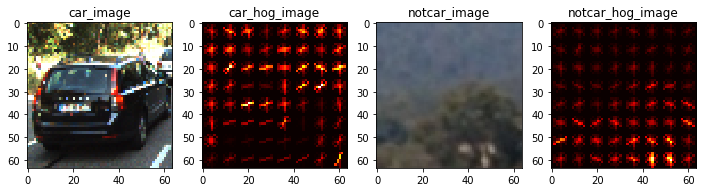

In [12]:
%matplotlib inline

# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'YCrCb'         # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0             # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)     # Spatial binning dimensions
hist_bins = 16              # Number of histogram bins   
spatial_feat = True         # Spatial features on or off
hist_feat = True            # Histogram features on or off
hog_feat = True             # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, 
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, 
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car_hog_image', 'notcar_image', 'notcar_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [ ]:
# Define feature parameters
color_space = 'YCrCb'         # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'         # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)     # Spatial binning dimensions
hist_bins = 16              # Number of histogram bins
spatial_feat = True         # Spatial features on or off
hist_feat = True            # Histogram features on or off
hog_feat = True             # HOG features on or off

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = cars # np.array(cars)[random_idxs]
test_notcars = notcars # np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block,',
     hist_bins,'histogram bins, and', spatial_size,'spatial sampling.')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
searchpath = './test_images/*'
example_images = glob.glob(searchpath)

images = []
titles = [] 

y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
x_start_stop = [416, 1280]
overlap = 0.8

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    image = img.astype(np.float32)/255     # png images (scaled 0 to 1 by mpimg) -> jpg (scaled 0 to 255)
    print(np.min(image), np.max(image))

    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    heat_map = np.zeros_like(img[:,:,0])
    heat_map = add_heat(heat_map, hot_windows)
    #heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')

fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)

In [ ]:
# out_images = []
# out_maps = []
# out_titles = []

# ystart = 400 
# ystop = 656
# scale = 1.5

# for img_src in example_images:
#     img = mpimg.imread(img_src)
#     out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     # heat_map = apply_threshold(heat_map, 1)
#     # labels = label(heat_map)
#     # Draw bounding boxes
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     out_images.append(draw_img)
#     out_images.append(heat_map)
#     out_titles.append(img_src[-12:])
#     out_titles.append(img_src[-12:])

# fig = plt.figure(figsize=(12,24))

# visualize(fig, 6, 2, out_images, out_titles)

In [ ]:
# def process_video(img):
#     out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     heat_map = apply_threshold(heat_map, 1)
#     labels = label(heat_map)
#     # Draw bounding boxes
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     return draw_img

In [ ]:
def process_video(img):

    y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
    x_start_stop = [416, 1280]
    overlap = 0.8

    image = img.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                        xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    heat_map = np.zeros_like(img[:,:,0])
    heat_map = add_heat(heat_map, hot_windows)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [ ]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# test_output = 'test_video_output.mp4'
# clip = VideoFileClip("test_video.mp4")
# test_clip = clip.fl_image(process_video)
# test_clip.write_videofile(test_output, audio=False)

In [ ]:
# video_output = 'project_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# video_clip = clip1.fl_image(process_video)
# video_clip.write_videofile(video_output, audio=False)